<h1>Learning Curve for br2_act: {ActCons, ActGen} 2013-2025<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Resources-used" data-toc-modified-id="Resources-used-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Resources used</a></span></li><li><span><a href="#Loading-and-preprocessing-data" data-toc-modified-id="Loading-and-preprocessing-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Loading and preprocessing data</a></span></li><li><span><a href="#Learning-Curve" data-toc-modified-id="Learning-Curve-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Learning Curve</a></span></li><li><span><a href="#Сore-Functions" data-toc-modified-id="Сore-Functions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Сore Functions</a></span></li><li><span><a href="#Search-max_depth" data-toc-modified-id="Search-max_depth-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Search max_depth</a></span></li></ul></div>

# Resources used

In [1]:
import os
import re
import locale
import requests
import warnings
import calendar
from bs4 import BeautifulSoup
from tqdm.notebook import trange

import notebook
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from platform import python_version
import xgboost as xgb
import graphviz
from datetime import time
from datetime import datetime
from datetime import timedelta
import sklearn
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LearningCurveDisplay

print(f"python: v {python_version()}")
print(f"Jupyter Notebook: v {notebook.__version__}")
print(f"numpy: v {np.__version__}")
print(f"pandas: v {pd.__version__}")
print(f"seaborn: v {sns.__version__}")
print(f"graphviz: v {graphviz.__version__}")
print(f"matplotlib: v {matplotlib.__version__}")
print(f"sklearn: v {sklearn.__version__}")
print(f"XGBoost: v {xgb.__version__}")

python: v 3.10.7
Jupyter Notebook: v 6.4.12
numpy: v 1.25.2
pandas: v 2.2.3
seaborn: v 0.13.2
graphviz: v 0.20.1
matplotlib: v 3.6.2
sklearn: v 1.4.2
XGBoost: v 2.1.2


# Loading and preprocessing data

Loading Data

In [2]:
df = pd.read_excel('DataBase.xlsx')

Create a global variable with a date indexed DataBase

In [3]:
df_general_date_index = df.set_index('Date')

Create an empty DataFrame (from 0:00 to 24:00) for the specified date

In [4]:
def get_empty_daily_df(date):
    return pd.DataFrame(pd.date_range(date, periods=25, freq='h'), columns=['Date'])

Replenishing the DataFrame with calendar categorical features

In [5]:
def add_date_scalar(df):
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] =  df.Date.dt.day
    df['Hour'] = df.Date.dt.hour
    df['Hour'] = df['Hour']
    df['Weekday'] = df.Date.dt.weekday
    return df

Getting weather on request from the DataBase

In [6]:
def get_weather(date):
    return get_empty_daily_df(date).merge(df_general_date_index.Temperature, how='left', on='Date').tail(24)

Obtaining Balancing energy Market (BM) data on request from the DataBase

In [7]:
def get_br_feature(date):    
    return get_empty_daily_df(date).merge(df_general_date_index[['PredCons', 'ActCons', 'PredGen',  'ActGen']], 
                                          how='left', on='Date')

Replacing gaps in *actual* (`Act`) consumption and generation BR-values with *planned* (`Pred`) BR-values

In [8]:
def act_pred_reverse(df_br_feature):
    
    df_br_feature.ActCons = np.where(df_br_feature.ActCons == 0, df_br_feature.PredCons, df_br_feature.ActCons)
    df_br_feature.ActGen = np.where(df_br_feature.ActGen == 0, df_br_feature.PredGen, df_br_feature.ActGen)
    
    # remove unnecessary (for further forecasting) features
    df_br_feature = df_br_feature.drop(columns=['PredCons', 'PredGen'])
    
    return df_br_feature

Preprocessing data

In [9]:
def get_type_day(df):  # coding of weekends and holidays
    
    holidays = [
                datetime(2013, 1, 1).date(), datetime(2013, 1, 2).date(), datetime(2013, 1, 3).date(), datetime(2013, 1, 4).date(), datetime(2013, 1, 5).date(), datetime(2013, 1, 6).date(), datetime(2013, 1, 7).date(), datetime(2013, 1, 8).date(), datetime(2013, 2, 23).date(), datetime(2013, 3, 8).date(), datetime(2013, 5, 1).date(), datetime(2013, 5, 9).date(), datetime(2013, 6, 12).date(), datetime(2013, 8, 8).date(), datetime(2013, 8, 30).date(), datetime(2013, 10, 15).date(), datetime(2013, 11, 4).date(), datetime(2013, 11, 6).date(),
                datetime(2014, 1, 1).date(), datetime(2014, 1, 2).date(), datetime(2014, 1, 3).date(), datetime(2014, 1, 4).date(), datetime(2014, 1, 5).date(), datetime(2014, 1, 6).date(), datetime(2014, 1, 7).date(), datetime(2014, 1, 8).date(), datetime(2014, 2, 23).date(), datetime(2014, 3, 8).date(), datetime(2014, 5, 1).date(), datetime(2014, 5, 9).date(), datetime(2014, 6, 12).date(), datetime(2014, 7, 28).date(), datetime(2014, 8, 30).date(), datetime(2014, 10, 4).date(), datetime(2014, 11, 4).date(), datetime(2014, 11, 6).date(),
                datetime(2015, 1, 1).date(), datetime(2015, 1, 2).date(), datetime(2015, 1, 3).date(), datetime(2015, 1, 4).date(), datetime(2015, 1, 5).date(), datetime(2015, 1, 6).date(), datetime(2015, 1, 7).date(), datetime(2015, 1, 8).date(), datetime(2015, 2, 23).date(), datetime(2015, 3, 8).date(), datetime(2015, 5, 1).date(), datetime(2015, 5, 9).date(), datetime(2015, 6, 12).date(), datetime(2015, 7, 17).date(), datetime(2015, 8, 30).date(), datetime(2015, 9, 24).date(), datetime(2015, 11, 4).date(), datetime(2015, 11, 6).date(),
                datetime(2016, 1, 1).date(), datetime(2016, 1, 2).date(), datetime(2016, 1, 3).date(), datetime(2016, 1, 4).date(), datetime(2016, 1, 5).date(), datetime(2016, 1, 6).date(), datetime(2016, 1, 7).date(), datetime(2016, 1, 8).date(), datetime(2016, 2, 23).date(), datetime(2016, 3, 8).date(), datetime(2016, 5, 1).date(), datetime(2016, 5, 9).date(), datetime(2016, 6, 12).date(), datetime(2016, 7, 5).date(), datetime(2016, 8, 30).date(), datetime(2016, 9, 12).date(), datetime(2016, 11, 4).date(), datetime(2016, 11, 6).date(),
                datetime(2017, 1, 1).date(), datetime(2017, 1, 2).date(), datetime(2017, 1, 3).date(), datetime(2017, 1, 4).date(), datetime(2017, 1, 5).date(), datetime(2017, 1, 6).date(), datetime(2017, 1, 7).date(), datetime(2017, 1, 8).date(), datetime(2017, 2, 23).date(), datetime(2017, 3, 8).date(), datetime(2017, 5, 1).date(), datetime(2017, 5, 9).date(), datetime(2017, 6, 12).date(), datetime(2017, 6, 25).date(), datetime(2017, 8, 30).date(), datetime(2017, 9, 1).date(), datetime(2017, 11, 4).date(), datetime(2017, 11, 6).date(),
                datetime(2018, 1, 1).date(), datetime(2018, 1, 2).date(), datetime(2018, 1, 3).date(), datetime(2018, 1, 4).date(), datetime(2018, 1, 5).date(), datetime(2018, 1, 6).date(), datetime(2018, 1, 7).date(), datetime(2018, 1, 8).date(), datetime(2018, 2, 23).date(), datetime(2018, 3, 8).date(), datetime(2018, 5, 1).date(), datetime(2018, 5, 9).date(), datetime(2018, 6, 12).date(), datetime(2018, 6, 15).date(), datetime(2018, 8, 21).date(), datetime(2018, 8, 30).date(), datetime(2018, 11, 4).date(), datetime(2018, 11, 6).date(),
                datetime(2019, 1, 1).date(), datetime(2019, 1, 2).date(), datetime(2019, 1, 3).date(), datetime(2019, 1, 4).date(), datetime(2019, 1, 5).date(), datetime(2019, 1, 6).date(), datetime(2019, 1, 7).date(), datetime(2019, 1, 8).date(), datetime(2019, 2, 23).date(), datetime(2019, 3, 8).date(), datetime(2019, 5, 1).date(), datetime(2019, 5, 9).date(), datetime(2019, 6, 4).date(), datetime(2019, 6, 12).date(), datetime(2019, 8, 11).date(), datetime(2019, 8, 30).date(), datetime(2019, 11, 4).date(), datetime(2019, 11, 6).date(),
                datetime(2020, 1, 1).date(), datetime(2020, 1, 2).date(), datetime(2020, 1, 3).date(), datetime(2020, 1, 4).date(), datetime(2020, 1, 5).date(), datetime(2020, 1, 6).date(), datetime(2020, 1, 7).date(), datetime(2020, 1, 8).date(), datetime(2020, 2, 23).date(), datetime(2020, 3, 8).date(), datetime(2020, 5, 1).date(), datetime(2020, 5, 9).date(), datetime(2020, 5, 24).date(), datetime(2020, 6, 12).date(), datetime(2020, 7, 31).date(), datetime(2020, 8, 30).date(), datetime(2020, 11, 4).date(), datetime(2020, 11, 6).date(),
                datetime(2021, 1, 1).date(), datetime(2021, 1, 2).date(), datetime(2021, 1, 3).date(), datetime(2021, 1, 4).date(), datetime(2021, 1, 5).date(), datetime(2021, 1, 6).date(), datetime(2021, 1, 7).date(), datetime(2021, 1, 8).date(), datetime(2021, 2, 23).date(), datetime(2021, 3, 8).date(), datetime(2021, 5, 1).date(), datetime(2021, 5, 9).date(), datetime(2021, 5, 13).date(), datetime(2021, 6, 12).date(), datetime(2021, 7, 20).date(), datetime(2021, 8, 30).date(), datetime(2021, 11, 4).date(), datetime(2021, 11, 4).date(),
                datetime(2022, 1, 1).date(), datetime(2022, 1, 2).date(), datetime(2022, 1, 3).date(), datetime(2022, 1, 4).date(), datetime(2022, 1, 5).date(), datetime(2022, 1, 6).date(), datetime(2022, 1, 7).date(), datetime(2022, 1, 8).date(), datetime(2022, 2, 23).date(), datetime(2022, 3, 8).date(), datetime(2022, 5, 1).date(), datetime(2022, 5, 2).date(), datetime(2022, 5, 9).date(), datetime(2022, 6, 12).date(), datetime(2022, 7, 9).date(), datetime(2022, 8, 30).date(), datetime(2022, 11, 4).date(), datetime(2022, 11, 6).date(),
                datetime(2023, 1, 1).date(), datetime(2023, 1, 2).date(), datetime(2023, 1, 3).date(), datetime(2023, 1, 4).date(), datetime(2023, 1, 5).date(), datetime(2023, 1, 6).date(), datetime(2023, 1, 7).date(), datetime(2023, 1, 8).date(), datetime(2023, 2, 23).date(), datetime(2023, 3, 8).date(), datetime(2023, 4, 21).date(), datetime(2023, 5, 1).date(), datetime(2023, 5, 9).date(), datetime(2023, 6, 12).date(), datetime(2023, 6, 28).date(), datetime(2023, 8, 30).date(), datetime(2023, 11, 4).date(), datetime(2023, 11, 6).date(),
                datetime(2024, 1, 1).date(), datetime(2024, 1, 2).date(), datetime(2024, 1, 3).date(), datetime(2024, 1, 4).date(), datetime(2024, 1, 5).date(), datetime(2024, 1, 6).date(), datetime(2024, 1, 7).date(), datetime(2024, 1, 8).date(), datetime(2024, 2, 23).date(), datetime(2024, 3, 8).date(), datetime(2024, 4, 10).date(), datetime(2024, 5, 1).date(), datetime(2024, 5, 9).date(), datetime(2024, 6, 12).date(), datetime(2024, 6, 16).date(), datetime(2024, 8, 30).date(), datetime(2024, 11, 4).date(), datetime(2024, 11, 6).date(),
                datetime(2025, 1, 1).date(), datetime(2025, 1, 2).date(), datetime(2025, 1, 3).date(), datetime(2025, 1, 4).date(), datetime(2025, 1, 5).date(), datetime(2025, 1, 6).date(), datetime(2025, 1, 7).date(), datetime(2025, 1, 8).date(), datetime(2025, 2, 23).date(), datetime(2025, 3, 8).date(), datetime(2025, 3, 30).date(), datetime(2025, 5, 1).date(), datetime(2025, 5, 9).date(), datetime(2025, 6, 6).date(), datetime(2025, 6, 12).date(), datetime(2025, 8, 30).date(), datetime(2025, 11, 4).date(), datetime(2025, 11, 6).date(),              
               ]
    
    weekend = [
               datetime(2013, 5, 2).date(), datetime(2013, 5, 3).date(), datetime(2013, 5, 10).date(),
               datetime(2014, 3, 10).date(), datetime(2014, 5, 2).date(), datetime(2014, 6, 13).date(), datetime(2014, 9, 1).date(), datetime(2014, 10, 6).date(), datetime(2014, 11, 3).date(), 
               datetime(2015, 1, 9).date(), datetime(2015, 3, 9).date(), datetime(2015, 5, 4).date(), datetime(2015, 5, 11).date(), datetime(2015, 8, 31).date(),
               datetime(2016, 2, 22).date(), datetime(2016, 3, 7).date(), datetime(2016, 5, 2).date(), datetime(2016, 5, 3).date(), datetime(2016, 6, 13).date(), datetime(2016, 11, 7).date(),
               datetime(2017, 2, 24).date(), datetime(2017, 5, 8).date(),
               datetime(2018, 3, 9).date(), datetime(2018, 4, 30).date(), datetime(2018, 5, 2).date(), datetime(2018, 6, 11).date(), datetime(2018, 11, 5).date(), datetime(2018, 12, 31).date(),
               datetime(2019, 5, 2).date(), datetime(2019, 5, 3).date(), datetime(2019, 5, 10).date(),
               datetime(2020, 2, 24).date(), datetime(2020, 3, 9).date(), datetime(2020, 5, 4).date(), datetime(2020, 5, 5).date(), datetime(2020, 5, 11).date(),
               datetime(2021, 2, 22).date(), datetime(2021, 5, 3).date(), datetime(2021, 5, 10).date(), datetime(2021, 6, 14).date(), datetime(2021, 11, 5).date(), datetime(2021, 12, 31).date(),
               datetime(2022, 3, 7).date(), datetime(2022, 5, 3).date(), datetime(2022, 5, 10).date(), datetime(2022, 6, 13).date(),
               datetime(2023, 2, 24).date(), datetime(2023, 5, 8).date(),
               datetime(2024, 4, 29).date(), datetime(2024, 4, 30).date(), datetime(2024, 5, 10).date(), datetime(2024, 12, 30).date(), datetime(2024, 12, 31).date(),
               datetime(2025, 5, 2).date(), datetime(2025, 5, 8).date(), datetime(2025, 6, 13).date(), datetime(2025, 11, 3).date(), datetime(2025, 12, 31).date() 
              ]
    
    pre_holidays = [
                    datetime(2013, 2, 22).date(), datetime(2013, 3, 7).date(), datetime(2013, 4, 30).date(), datetime(2013, 5, 8).date(), datetime(2013, 6, 11).date(), datetime(2013, 8, 7).date(), datetime(2013, 8, 29).date(), datetime(2013, 10, 14).date(), datetime(2013, 11, 5).date(), datetime(2013, 12, 31).date(),
                    datetime(2014, 2, 24).date(), datetime(2014, 3, 7).date(), datetime(2014, 4, 30).date(), datetime(2014, 5, 8).date(), datetime(2014, 6, 11).date(), datetime(2014, 8, 29).date(), datetime(2014, 10, 3).date(), datetime(2014, 11, 5).date(), datetime(2014, 12, 31).date(),
                    datetime(2015, 4, 30).date(), datetime(2015, 5, 8).date(), datetime(2015, 6, 11).date(), datetime(2015, 7, 16).date(), datetime(2015, 9, 23).date(), datetime(2015, 11, 3).date(), datetime(2015, 11, 5).date(), datetime(2015, 12, 31).date(),
                    datetime(2016, 2, 20).date(), datetime(2016, 7, 4).date(), datetime(2016, 8, 29).date(), datetime(2016, 11, 3).date(),
                    datetime(2017, 2, 22).date(), datetime(2017, 3, 7).date(), datetime(2017, 8, 29).date(), datetime(2017, 8, 31).date(), datetime(2017, 11, 3).date(),            
                    datetime(2018, 2, 22).date(), datetime(2018, 3, 7).date(), datetime(2018, 4, 28).date(), datetime(2018, 5, 8).date(), datetime(2018, 6, 9).date(), datetime(2018, 6, 14).date(), datetime(2018, 7, 20).date(), datetime(2018, 7, 29).date(), datetime(2018, 12, 29).date(),
                    datetime(2019, 2, 22).date(), datetime(2019, 3, 7).date(), datetime(2019, 4, 30).date(), datetime(2019, 5, 8).date(), datetime(2019, 6, 3).date(), datetime(2019, 6, 11).date(), datetime(2019, 8, 29).date(), datetime(2019, 11, 5).date(), datetime(2019, 12, 31).date(),
                    datetime(2020, 4, 30).date(), datetime(2020, 5, 8).date(), datetime(2020, 6, 11).date(), datetime(2020, 7, 30).date(), datetime(2020, 11, 3).date(), datetime(2020, 11, 5).date(), datetime(2020, 12, 31).date(),
                    datetime(2021, 2, 20).date(), datetime(2021, 4, 30).date(), datetime(2021, 5, 12).date(), datetime(2021, 6, 11).date(), datetime(2021, 7, 19).date(), datetime(2021, 11, 3).date(),
                    datetime(2022, 2, 22).date(), datetime(2022, 3, 5).date(), datetime(2022, 7, 8).date(), datetime(2022, 8, 29).date(), datetime(2022, 11, 3).date(),
                    datetime(2023, 2, 22).date(), datetime(2023, 3, 7).date(), datetime(2023, 4, 20).date(),  datetime(2023, 6, 27).date(), datetime(2023, 8, 29).date(), datetime(2023, 11, 3).date(),
                    datetime(2024, 2, 22).date(), datetime(2024, 3, 7).date(), datetime(2024, 4, 9).date(), datetime(2024, 5, 8).date(), datetime(2024, 6, 11).date(), datetime(2024, 8, 29).date(), datetime(2024, 11, 2).date(), datetime(2024, 11, 5).date(),
                    datetime(2025, 3, 7).date(), datetime(2025, 4, 30).date(), datetime(2025, 6, 5).date(), datetime(2025, 6, 11).date(), datetime(2025, 8, 29).date(), datetime(2025, 11, 1).date(), datetime(2025, 11, 5).date()
                   ]
    
    workdays = [datetime(2024, 4, 27).date(), datetime(2024, 12, 28).date()]
    
    if df.Date.date() in workdays:
        TypeDay = 0
    elif df.Date.date() in pre_holidays:
        TypeDay = 1   
    elif df.Date.date() in weekend:
        TypeDay = 3 
    elif df.Date.date() in holidays:
        TypeDay = 2 
    elif (df.Weekday == 5) | (df.Weekday == 6):
        TypeDay = 3
    else:
        TypeDay = 0
    return TypeDay

In [10]:
def prepareData(df, lag_start=1, lag_end=7):        
        
    # coding of weekends and holidays
    df['TypeDay'] = df.apply(get_type_day, axis=1)
    
    df = df.set_index('Date')
    
    # add daily lags of the original series (default is 1 full week)
    for i in range(lag_start, lag_end + 1):    
        df[f"lag-{i}"] = df.Volume.shift(freq=f"{i}D")  # we make a shift to the i-th day by index 

    # delete the first 24*lag_end records with missing data (168 records for a lag of 7 days)
    df = df.dropna(subset=['lag-1', 'lag-2', 'lag-3', 'lag-4', 'lag-5', 'lag-6', 'lag-7'])
    df.reset_index(inplace=True)
    
    return df

Adding/removing/changing features

In [11]:
# we form a general population
df_general = df.copy()

# adding new features
df_general = prepareData(df_general)

# we delete columns with forecast values of electricity consumption and generation in the Balancing Market
df_general = df_general.drop(columns=['PredCons', 'PredGen', 'Price'])

df_general.iloc[:, 1:]

,Year,Month,Day,Hour,Weekday,Volume,Temperature,ActCons,ActGen,TypeDay,lag-1,lag-2,lag-3,lag-4,lag-5,lag-6,lag-7
0,2013,1,8,1,1,2017.102000,-6.1,2875,2568,2,1983.630000,1984.007000,2000.216000,1972.473000,2008.811000,2027.193000,2033.264000
1,2013,1,8,2,1,1964.942000,-6.1,2781,2580,2,1932.213000,1934.204000,1950.523000,1920.304000,1953.228000,1970.887000,1987.714000
2,2013,1,8,3,1,1938.221000,-6.0,2737,2581,2,1904.510000,1907.831000,1920.106000,1889.606000,1915.720000,1938.669000,1955.861000
3,2013,1,8,4,1,1929.957000,-6.0,2761,2576,2,1895.918000,1897.508000,1915.331000,1882.192000,1904.349000,1931.414000,1944.520000
4,2013,1,8,5,1,1950.473000,-6.0,2763,2575,2,1921.034000,1904.977000,1922.729000,1902.160000,1905.641000,1939.466000,1964.332000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108859,2025,6,9,20,0,2721.774653,25.8,4290,3728,0,2598.823747,2495.932241,2509.170162,2561.903797,2539.725131,2563.724502,2613.908383
108860,2025,6,9,21,0,2730.908830,24.0,4295,3607,0,2635.572995,2531.893929,2575.182469,2598.473502,2584.616371,2607.633057,2622.134405
108861,2025,6,9,22,0,2760.499815,22.5,4215,3022,0,2644.562278,2536.011304,2580.107662,2611.434013,2583.034630,2633.566958,2591.983765
108862,2025,6,9,23,0,2602.230175,21.7,3994,2961,0,2488.318808,2416.546642,2469.557023,2468.343446,2418.571382,2465.536150,2442.039994


# Learning Curve

Splitted the target and initial features

In [12]:
def X_y_split(df_general, datetime=df_general.Date.iloc[-1]):
    
    # take the maximum available sample for 2025 - 12 years
    df_train = df_general[(df_general.Date > datetime - timedelta(days=365*7+3, hours=0)) &
                          (df_general.Date <= datetime)]
    
    return df_train.drop(columns=['Date', 'Volume']), df_train.Volume

Building a learning curve

<Figure size 1000x500 with 0 Axes>

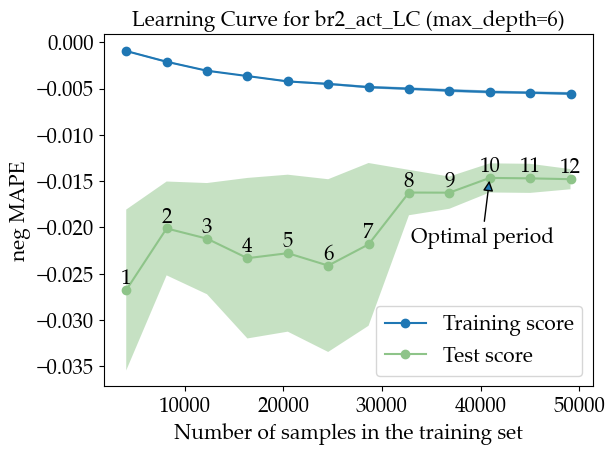

In [57]:
def draw_learning_curve(df_general, max_depth=6, fontsize=15):  
    
    X, y = X_y_split(df_general)

    model = xgb.XGBRegressor(device = 'cpu',
                             n_estimators = 200,
                             max_depth = max_depth)
    common_params = {
                     "X": X,
                     "y": y,
                     "train_sizes": np.linspace(1/12, 1.0, 12),
                     "cv": 5,
                     "scoring": 'neg_mean_absolute_percentage_error',
                     "n_jobs": -1,
                     "line_kw": {"marker": "o"},
                     "std_display_style": "fill_between",
                     "score_name": "neg MAPE",
                    }

    plt.figure(figsize=(10, 5))
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#1f77b4', '#8ec489']) 
    plt.rcParams['font.family'] = 'Palatino Linotype'
    plt.rcParams['font.size'] = fontsize    
    
    LCD = LearningCurveDisplay.from_estimator(model, **common_params)
    train_sizes = LCD.train_sizes
    test_scores = LCD.test_scores
    mean_test_scores = [test_scores[i].mean() for i in range(len(test_scores))]    
    opt_y = max(mean_test_scores)
    opt_x = train_sizes[mean_test_scores.index(opt_y)]
    
    for i in range(len(mean_test_scores)):
        plt.text(train_sizes[i], mean_test_scores[i], f'{i+1}', ha='center', va='bottom')
    
    plt.annotate('Optimal period', xy=(opt_x, opt_y), 
                 xycoords='data', xytext=(opt_x-8000, opt_y-0.007), 
                 textcoords='data', fontsize=fontsize, 
                 arrowprops=dict(arrowstyle='-|>'))
    
    plt.title(f'Learning Curve for br2_act_LC (max_depth={max_depth})', fontsize=fontsize)
    plt.legend(['Training score', 'Test score'], loc='lower right')
    plt.tight_layout()
    plt.savefig(f'pictures/br2_Learning_Curve(max_depth={max_depth}).png', dpi = 300, transparent = True)
    plt.show()
    
draw_learning_curve(df_general)

# Сore Functions

Function of model training and forecasting energy consumption volumes

In [28]:
def predict_volume(df_general, period, max_depth, df_predict, datetime):

    df_train = df_general[df_general.Date > datetime - timedelta(days=365*period+1, hours=1)]

    model = xgb.XGBRegressor(device = 'cpu',
                             n_estimators = 200,
                             max_depth = max_depth)

    model.fit(df_train.drop(columns=['Date', 'Volume']), df_train.Volume)

    df_predict.Volume = model.predict(df_predict.drop(columns=['Date', 'Volume']))
   
    return df_predict

Function for generating a DataFrame with predicted energy consumption volumes for a specified planning horizon

In [29]:
# define the planning horizon (by default – one day ahead from the current date)
def get_df_predicted(df_general,
                     period, 
                     max_depth,
                     date_start=datetime.now().date(), 
                     date_end=datetime.now().date() + timedelta(days=1)):

    # generate an empty dataframe for the final result
    df_predicted = pd.DataFrame()

    for date in range((date_end - date_start).days + 1):

        # generate an empty daily dataframe with weather and calendar attributes
        df_predicted_daily = add_date_scalar(get_weather(date_start + timedelta(days=date)))

        # divide the learning logic (current day taking into account BR, subsequent days - without taking into account BR)
        if date == 0:
            
            # download data (forecast and some actual) from the balancing market for the current day
            df_predicted_daily = df_predicted_daily.merge(get_br_feature(date_start), on='Date')
            
            # reset all actual from 8:00 in df_predicted_daily (to simulate real conditions)
            df_predicted_daily.loc[df_predicted_daily.Date >= datetime.combine(date_start, time(hour=8)),
                                   ['ActCons', 'ActGen']] = 0

            # restore gaps ActCons and ActGen with data from columns PredCons and PredGen
            df_predicted_daily = act_pred_reverse(df_predicted_daily)
            
        elif date == 1:
            df_general = df_general.drop(columns=['ActCons', 'ActGen'])

        # add last 168 (24 · 7) rows from df_general to generate time lag
        df_predicted_daily = pd.concat(
            [df_general.tail(168), df_predicted_daily])

        # generate a time lag (1 full week)
        df_predicted_daily = prepareData(df_predicted_daily)

        # get forecast values for the current day
        df_predicted_daily = predict_volume(df_general,
                                            period, 
                                            max_depth,
                                            df_predicted_daily, 
                                            datetime.combine(date_start + timedelta(days=date), time(hour=1)))

        # add the obtained forecast values to the final forecast frame
        df_predicted = pd.concat([df_predicted, df_predicted_daily])

        # replenish the general set with the current days (+24 lines) to plan the next day
        df_general = pd.concat([df_general, df_predicted_daily])

    df_predicted.rename(columns={'Volume': 'Predicted'}, inplace=True)

    return df_predicted[['Date', 'Predicted']].tail(24)

# Search max_depth

Determine the size of the validation sample

In [31]:
# fragment of 2025
df_validate = df_general[(df_general.Date > datetime(2025, 1, 1, 0))]

df_validate.reset_index(drop=True, inplace=True)
df_validate.iloc[:, :-7]

,Date,Year,Month,Day,Hour,Weekday,Volume,Temperature,ActCons,ActGen,TypeDay
0,2025-01-01 01:00:00,2025,1,1,1,2,2524.247000,-1.6,3922,3237,2
1,2025-01-01 02:00:00,2025,1,1,2,2,2476.771000,-2.4,3868,3240,2
2,2025-01-01 03:00:00,2025,1,1,3,2,2411.522000,-3.0,3801,3215,2
3,2025-01-01 04:00:00,2025,1,1,4,2,2369.143000,-3.1,3729,3211,2
4,2025-01-01 05:00:00,2025,1,1,5,2,2347.515000,-3.0,3713,3214,2
...,...,...,...,...,...,...,...,...,...,...,...
3835,2025-06-09 20:00:00,2025,6,9,20,0,2721.774653,25.8,4290,3728,0
3836,2025-06-09 21:00:00,2025,6,9,21,0,2730.908830,24.0,4295,3607,0
3837,2025-06-09 22:00:00,2025,6,9,22,0,2760.499815,22.5,4215,3022,0
3838,2025-06-09 23:00:00,2025,6,9,23,0,2602.230175,21.7,3994,2961,0


In [43]:
%%time

# Create an empty dataframe for the search results
df_search_result = pd.DataFrame(columns=['period', 'max_depth', 'MAPE'])

# grid node index of the resulting dataframe
index = 0  

# form a grid of hyperparameters
for max_depth in trange(3, 7, desc=f"total progress"):
    
    period = 10  # set based on the results of the Learning Curve
    
    # final validation dataframe with predicted values
    df_validate_result = pd.DataFrame()

    # daily validation for the selected interval with the daily calculation process widget
    for i in trange(int((df_validate.shape[0]) / 24), 
                    desc=f"days progress (period: {period}, max_depth: {max_depth})"):

        # form the forecast date
        idate = df_validate.iloc[0].Date + timedelta(days=i)

        # limit the size of the general population (up to -2 days before the forecast date)
        df_general_cut = df_general[df_general.Date < idate - timedelta(days=1)]

        # make a forecast for the specified date (taking into account -1 day)
        df_predicted = get_df_predicted(df_general_cut,
                                        period, 
                                        max_depth,
                                        date_start=idate.date()-timedelta(days=1), 
                                        date_end=idate.date())

        # fill the validation frame with predicted values
        df_validate_result = pd.concat([df_validate_result, df_validate.merge(df_predicted, how='left', on='Date')])
        df_validate_result.dropna(inplace=True)
            
    # fill the resulting dataframe with metrics and model parameters
    df_search_result.loc[index] = (period,
                                    max_depth,
                                    MAPE(df_validate_result.Predicted, df_validate_result.Volume))
    index += 1;

total progress:   0%|          | 0/4 [00:00<?, ?it/s]

days progress (period: 10, max_depth: 3):   0%|          | 0/160 [00:00<?, ?it/s]

days progress (period: 10, max_depth: 4):   0%|          | 0/160 [00:00<?, ?it/s]

days progress (period: 10, max_depth: 5):   0%|          | 0/160 [00:00<?, ?it/s]

days progress (period: 10, max_depth: 6):   0%|          | 0/160 [00:00<?, ?it/s]

CPU times: total: 1h 52min 28s
Wall time: 15min 33s


Export the resulting DataFrame to an *.xlsx file

In [44]:
df_search_result.to_excel(f'GridSearch_br2_act_LC_2025_p10.xlsx', index=False)

Displaying search results

In [45]:
search_result = df_search_result.copy()

search_result = search_result.style.format({'MAPE': '{:.3%}',
                                            }).background_gradient(cmap=sns.color_palette("vlag", as_cmap=True))

n = df_search_result.MAPE.idxmin()
print(f'Best results (MAPE: {df_search_result.loc[n].MAPE:.3%}) obtained for the parameters: ',
      f'Period: {df_search_result.loc[n].period}',
      f'max_depth: {df_search_result.loc[n].max_depth}', sep='\n')

search_result

Best results (MAPE: 1.447%) obtained for the parameters: 
Period: 10.0
max_depth: 5.0


,period,max_depth,MAPE
0,10.000000,3.000000,1.507%
1,10.000000,4.000000,1.497%
2,10.000000,5.000000,1.447%
3,10.000000,6.000000,1.476%
